In [31]:
#show the oil/gas type and gor relation
import pandas as pd

anp = pd.read_csv('../data/br_geodata/data_standardization/anp.csv')
wm = pd.read_csv('../data/br_geodata/data_standardization/wm.csv')
zhan = pd.read_csv('../data/br_geodata/data_standardization/zhan.csv')
pyxis = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table.csv')

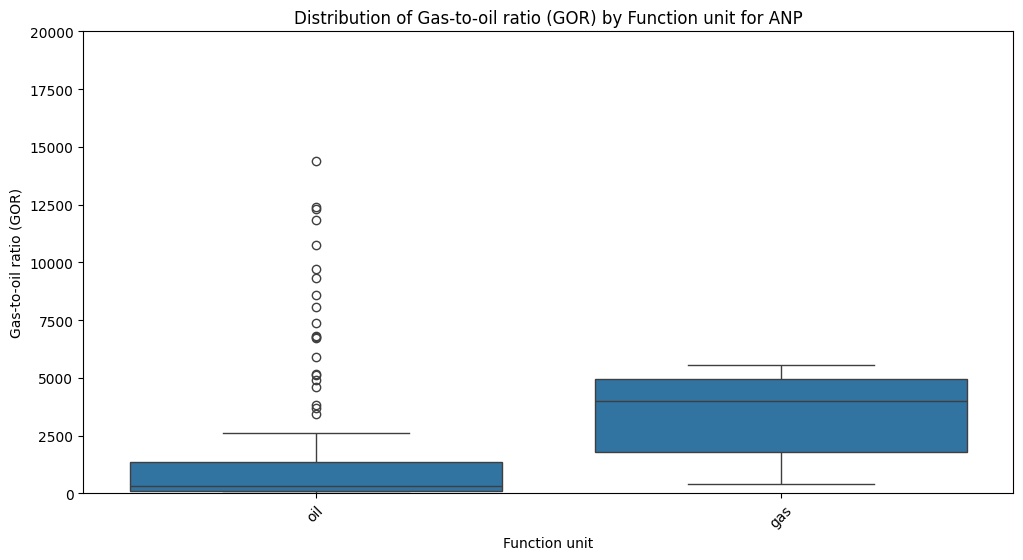

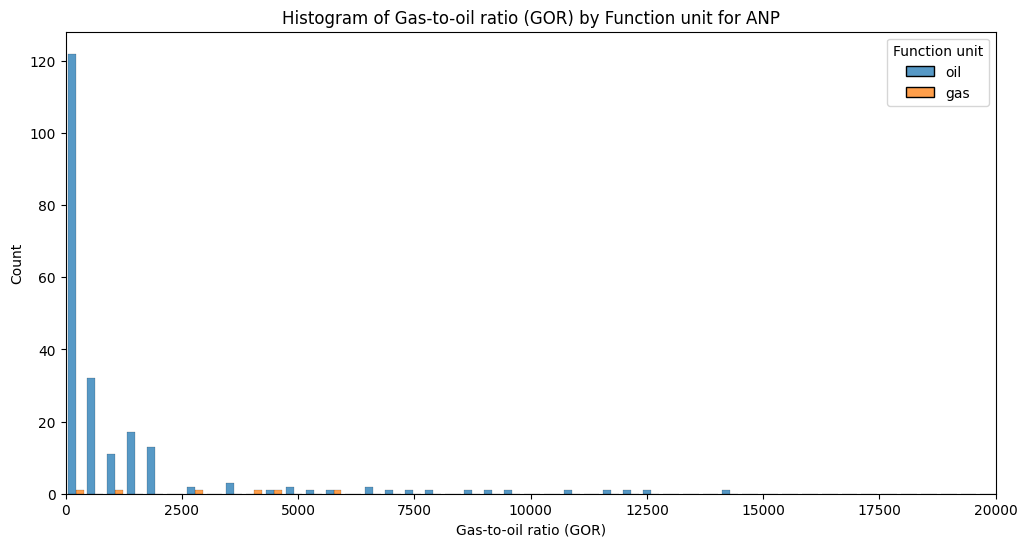

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_distribution(df, category_col, num_col, dfname, lim = 100000):
    # Check if both columns exist in the DataFrame
    if category_col not in df.columns or num_col not in df.columns:
        print(f"Error: Columns '{category_col}' and/or '{num_col}' do not exist in the DataFrame.")
        return
    
    # Plot box plot
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x=category_col, y=num_col, data=df)
    ax.set_ylim(0, lim)
    plt.title(f'Distribution of {num_col} by {category_col} for {dfname}')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(data=df, x=num_col, hue=category_col, multiple="dodge", shrink=.8)
    ax.set_xlim(0, lim)
    plt.title(f'Histogram of {num_col} by {category_col} for {dfname}')
    plt.show()

plot_category_distribution(anp,'Function unit','Gas-to-oil ratio (GOR)','ANP',lim=20000)

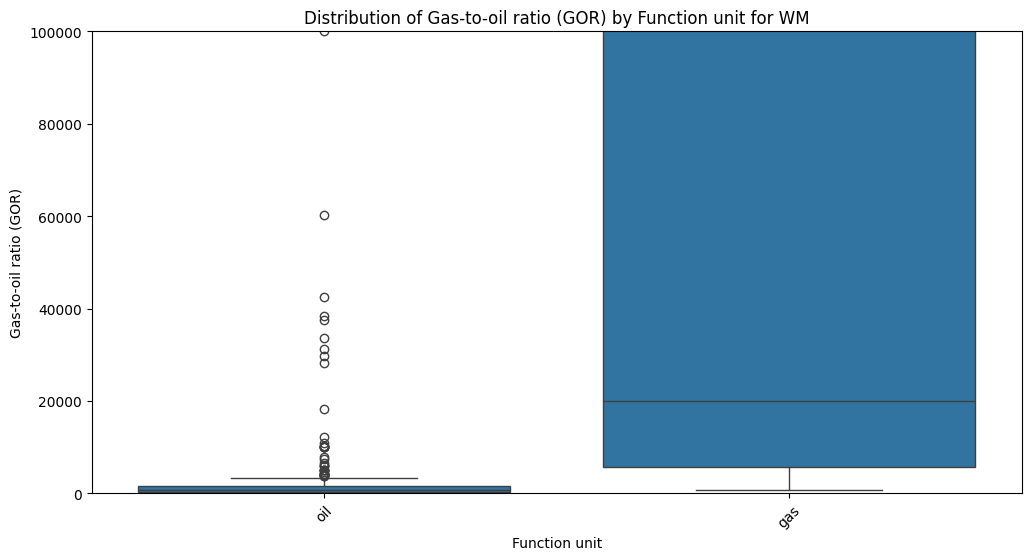

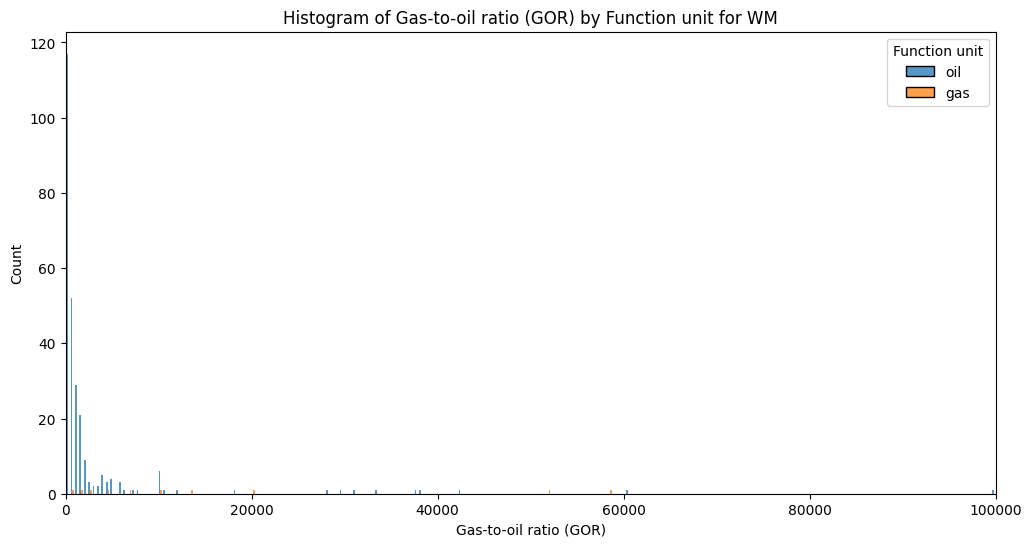

In [33]:
plot_category_distribution(wm,'Function unit','Gas-to-oil ratio (GOR)','WM')

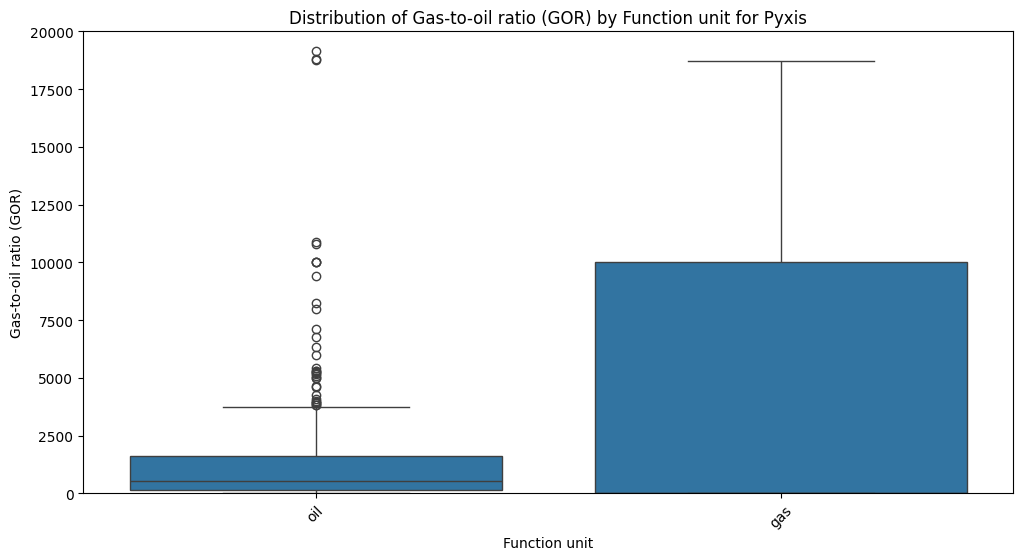

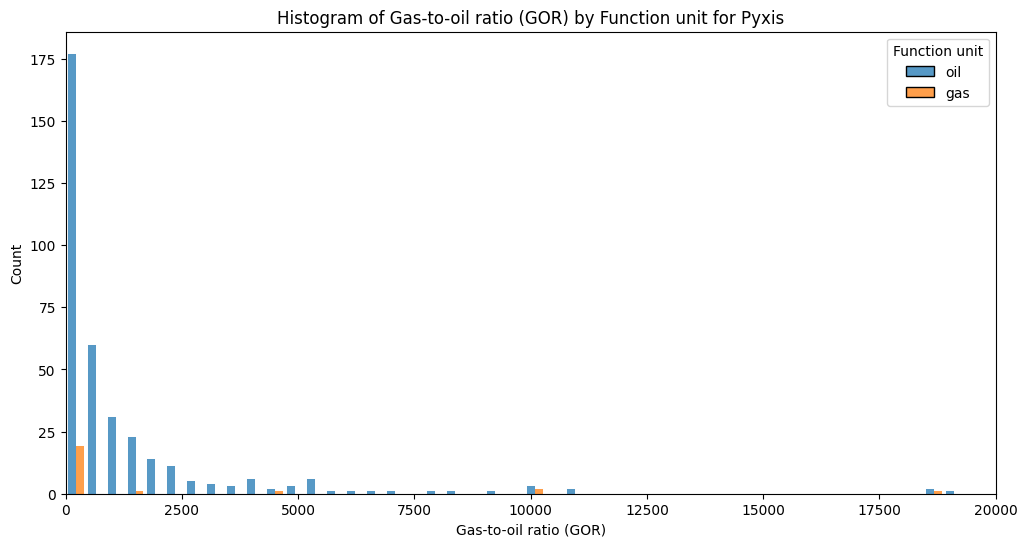

In [34]:
plot_category_distribution(pyxis,'Function unit','Gas-to-oil ratio (GOR)','Pyxis',lim=20000)

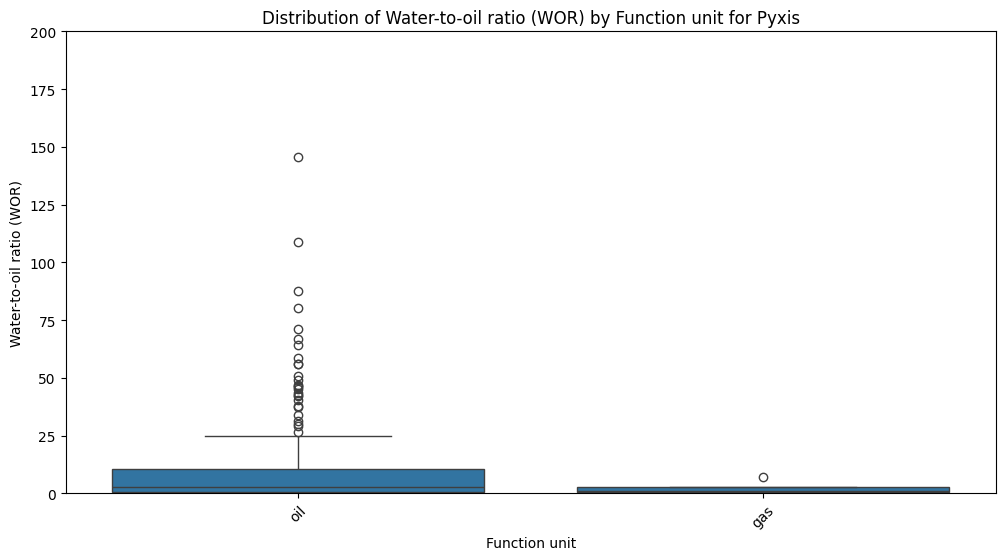

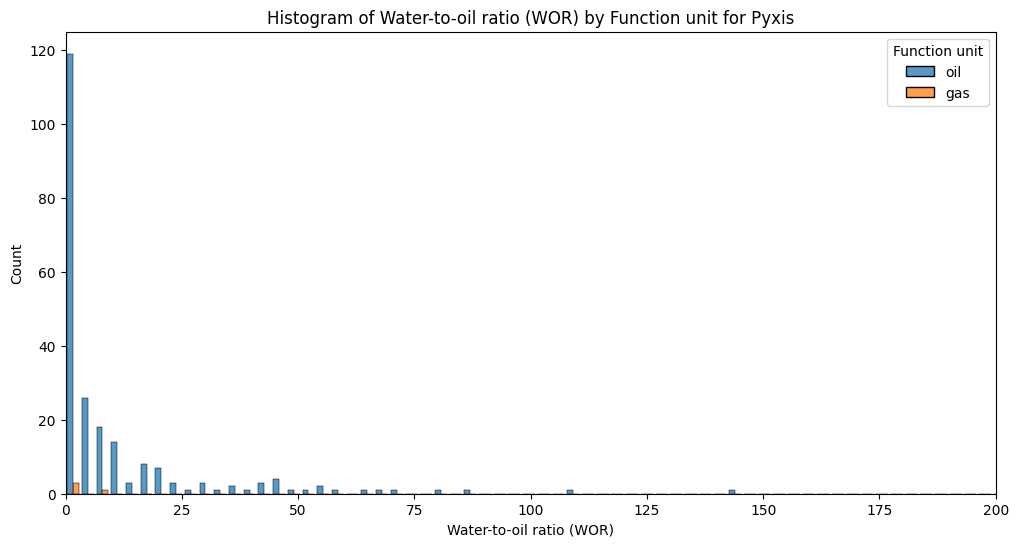

In [39]:
plot_category_distribution(pyxis,'Function unit','Water-to-oil ratio (WOR)','Pyxis',lim=200)

In [171]:
#wm field need to be cleaned further
#check for unpair field status
import geopandas as gpd

wm = gpd.read_file('../data/br_geodata/wm/BR.shp')

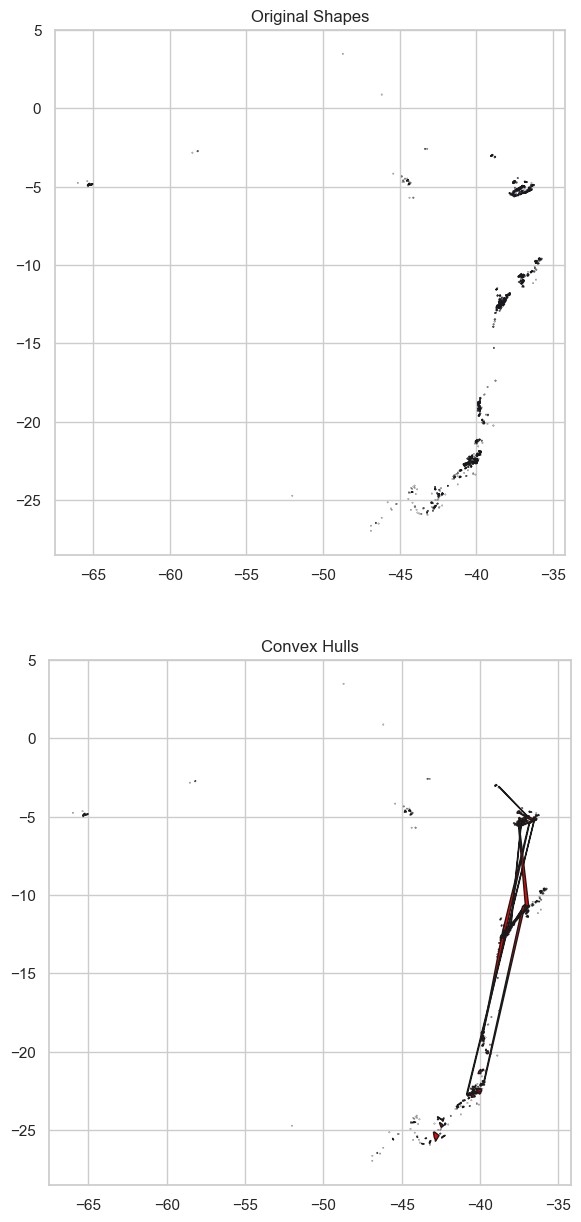

In [172]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def plot_convex_hulls(gdf):
    """
    Plot the original geometries and their convex hulls from a shapefile."""

    # Initialize an empty list to store convex hulls
    hull_list = []

    # Compute the convex hull for each geometry
    for index, row in gdf.iterrows():
        convex_hull = row.geometry.convex_hull
        hull_list.append(gpd.GeoSeries([convex_hull]))

    # Create a GeoDataFrame from the list of convex hulls
    hulls = gpd.GeoDataFrame(pd.concat(hull_list, ignore_index=True), columns=['geometry'])

    # Plotting the original shapes and the convex hulls
    fig, axs = plt.subplots(2, 1, figsize=(10, 15))

    # Plot original shapes
    gdf.plot(ax=axs[0], color='blue', edgecolor='k')
    axs[0].set_title("Original Shapes")  # Set title for the first subplot

    # Plot convex hulls
    hulls.plot(ax=axs[1], color='red', edgecolor='k')
    axs[1].set_title("Convex Hulls")  # Set title for the second subplot

    plt.show()

plot_convex_hulls(wm)

In [173]:
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, Point
from sklearn.cluster import DBSCAN
import numpy as np

def clean_multipolygons(gdf, eps=10, min_samples=1):
    """
    Clean a GeoDataFrame by applying DBSCAN clustering to each MultiPolygon.
    This function breaks down MultiPolygons, clusters the individual Polygons based on
    centroid proximity, and retains only those in the largest cluster.

    Parameters:
    - gdf (GeoDataFrame): The GeoDataFrame containing the geometries.
    - eps (float): The maximum distance between centroids for clustering (default 10 km).
    - min_samples (int): The minimum number of samples in a neighborhood for considering a core point.
    """
    cleaned_geometries = []
    eps = eps/6371.0088
    
    for geometry in gdf['geometry']:
        if isinstance(geometry, Polygon):
            cleaned_geometries.append(geometry)
            continue
        
        # Extract centroids of individual polygons if it's a MultiPolygon
        if isinstance(geometry, MultiPolygon):
            polygons = list(geometry.geoms)
            centroids = np.array([poly.centroid.coords[0] for poly in polygons])
            
            # Apply DBSCAN clustering on these centroids
            db = DBSCAN(eps=eps, min_samples=min_samples,metric='haversine').fit(centroids)
            labels = db.labels_
            # Group polygons by cluster label to find the largest cluster
            clusters = {}
            for label, polygon in zip(labels, polygons):
                if label in clusters:
                    clusters[label].append(polygon)
                else:
                    clusters[label] = [polygon]
            
            # Determine the largest cluster (ignoring noise label -1)
            largest_cluster = max((v for k, v in clusters.items() if k != -1), key=len, default=None)
            
            # Construct the output geometry from the largest cluster
            if largest_cluster:
                if len(largest_cluster) == 1:
                    cleaned_geometries.append(largest_cluster[0])
                else:
                    cleaned_geometries.append(MultiPolygon(largest_cluster))
            else:
                cleaned_geometries.append(None)  # Append None if no valid cluster exists

    # Replace old geometries with cleaned ones and remove None entries
    gdf['geometry'] = cleaned_geometries
    return gdf.dropna(subset=['geometry'])

# Example usage:
cleaned_gdf = clean_multipolygons(wm, min_samples=1)


In [174]:
cleaned_gdf

,id_field_a,f_depth_mt,waterw_cnt,prodw_cnt,Unnamed_ 0,id_field_p,id_field,field_name,id_field_g,field_grou,...,f_breake_9,f_breake10,f_breake11,f_pi_ratio,f_pi_rat_1,f_pi_rat_2,f_payback_,f_paybac_1,f_paybac_2,geometry
0,8897.0,2711.334000,0,37,30379,9acf7769aeea55e2b2505c88710d4293,8897,Leste do Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.20221 -4.91142, -65.20296 -4.911..."
1,8898.0,2931.312273,0,38,6506,45988a729df28f554d96a5b9932b17e1,8898,Rio Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.30670 -4.94209, -65.30723 -4.942..."
2,8899.0,1316.921767,9,331,23624,75ac2c91d93efba8651671f18ec013d0,8899,Agua Grande,53241,Polo Rio Ventura,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.37040 -12.41547, -38.37059 -12.4..."
3,8900.0,2462.733333,0,5,2887,eedc6ed006e6f49a7010013cc1fd8a3f,8900,Apraius,54046,Polo Miranga,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.16621 -12.28790, -38.16708 -12.2..."
4,8901.0,2299.792487,25,289,21865,f4d87ed3b0dbf9c79746d00cedbb5e78,8901,Aracas,54047,Polo Bahia Terra,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.18998 -12.17233, -38.19057 -12.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,52671.0,2571.000000,0,0,678,3e91c64374748139567aa5f3d103bb93,52671,Campainha Azul,52671,Campainha Azul,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-36.91129 -5.30779, -36.91134 -5.308..."
524,53346.0,1121.000000,0,4,13191,f5bff02c9cd125d255a41bba3ff614aa,53346,Suindara,53346,Suindara,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-39.82797 -19.19771, -39.82818 -19.1..."
525,53497.0,1852.166667,0,2,12767,f16b1d1dec14dd6a94a580ca4894d11f,53497,Gaviao Belo,42941,Parque dos Gavioes,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-44.10053 -5.71356, -44.10074 -5.714..."
526,53569.0,3677.000000,0,0,1135,15b6f28363206ef318d53ecd59b53dfb,53569,Murucututu,53569,Murucututu,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-38.18539 -12.45179, -38.18544 -12.4..."


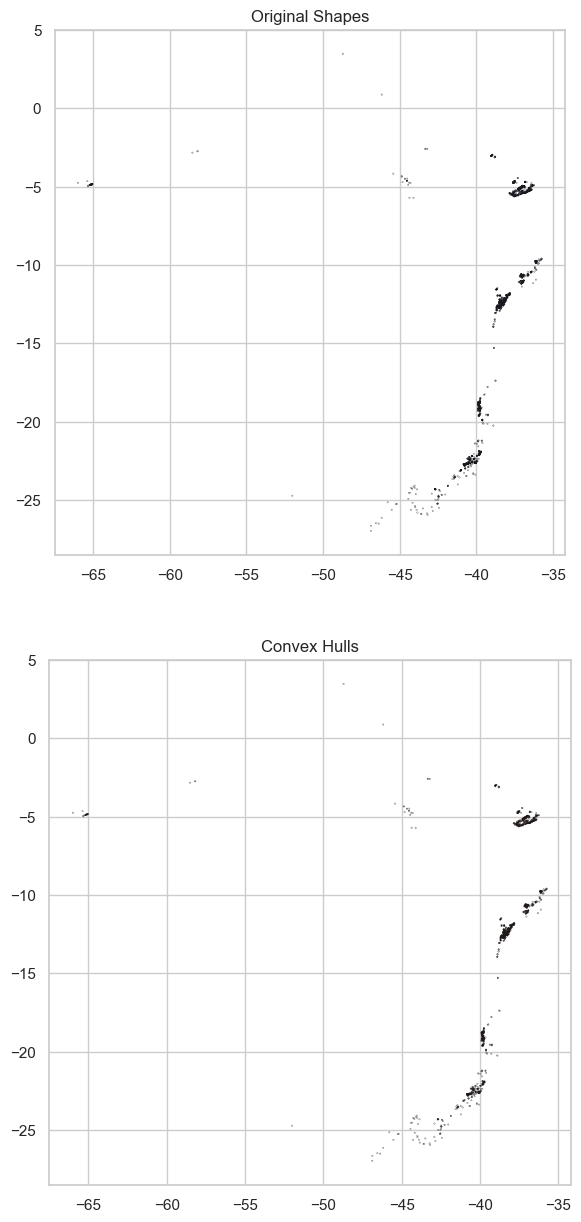

In [175]:
plot_convex_hulls(cleaned_gdf)

In [60]:
cleaned_gdf

,id_field_a,f_depth_mt,waterw_cnt,prodw_cnt,Unnamed_ 0,id_field_p,id_field,field_name,id_field_g,field_grou,...,f_breake_9,f_breake10,f_breake11,f_pi_ratio,f_pi_rat_1,f_pi_rat_2,f_payback_,f_paybac_1,f_paybac_2,geometry
0,8897.0,2711.334000,0,37,30379,9acf7769aeea55e2b2505c88710d4293,8897,Leste do Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.20221 -4.91142, -65.20296 -4.911..."
1,8898.0,2931.312273,0,38,6506,45988a729df28f554d96a5b9932b17e1,8898,Rio Urucu,12570,Urucu Area,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-65.30670 -4.94209, -65.30723 -4.942..."
2,8899.0,1316.921767,9,331,23624,75ac2c91d93efba8651671f18ec013d0,8899,Agua Grande,53241,Polo Rio Ventura,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.37040 -12.41547, -38.37059 -12.4..."
3,8900.0,2462.733333,0,5,2887,eedc6ed006e6f49a7010013cc1fd8a3f,8900,Apraius,54046,Polo Miranga,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.16621 -12.28790, -38.16708 -12.2..."
4,8901.0,2299.792487,25,289,21865,f4d87ed3b0dbf9c79746d00cedbb5e78,8901,Aracas,54047,Polo Bahia Terra,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.18998 -12.17233, -38.19057 -12.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,52671.0,2571.000000,0,0,678,3e91c64374748139567aa5f3d103bb93,52671,Campainha Azul,52671,Campainha Azul,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-36.91129 -5.30779, -36.91134 -5.308..."
524,53346.0,1121.000000,0,4,13191,f5bff02c9cd125d255a41bba3ff614aa,53346,Suindara,53346,Suindara,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-39.82797 -19.19771, -39.82818 -19.1..."
525,53497.0,1852.166667,0,2,12767,f16b1d1dec14dd6a94a580ca4894d11f,53497,Gaviao Belo,42941,Parque dos Gavioes,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-44.10053 -5.71356, -44.10074 -5.714..."
526,53569.0,3677.000000,0,0,1135,15b6f28363206ef318d53ecd59b53dfb,53569,Murucututu,53569,Murucututu,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-38.18539 -12.45179, -38.18544 -12.4..."


In [177]:
df = gpd.read_file('../data/br_geodata/merged_pyxis_field_info_table.csv', ignore_geometry=True)
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
pyxis = gpd.GeoDataFrame(df)

In [181]:
pyxis.to_file('../data/br_geodata/merged_pyxis.geojson')


In [182]:
def save_convex_hulls(gdf):
    """
    Plot the original geometries and their convex hulls from a shapefile."""

    # Initialize an empty list to store convex hulls
    hull_list = []

    # Compute the convex hull for each geometry
    for index, row in gdf.iterrows():
        convex_hull = row.geometry.convex_hull
        hull_list.append(gpd.GeoSeries([convex_hull]))

    # Create a GeoDataFrame from the list of convex hulls
    hulls = gpd.GeoDataFrame(pd.concat(hull_list, ignore_index=True), columns=['geometry'])

    gdf_hull = gdf
    gdf_hull['geometry']=hulls
    return gdf_hull

pyxis_hull = save_convex_hulls(pyxis)
pyxis_hull.to_file('../data/br_geodata/merged_pyxis_convexhull.geojson')


/Users/yaqifan/Documents/Github/Pyxis/db/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [146]:
pyxis.to_file('../data/br_geodata/merged_pyxis.geojson', driver="GeoJSON")

In [3]:
#20240531 - check pyxis match table to see what fields don't have match -> 405 valid government field with names and final pyxis field 572 fields
import pandas as pd
match = pd.read_csv('../data/br_geodata/pyxis_match_table.csv')
anp = pd.read_csv('../data/br_geodata/data_standardization/anp.csv')
wm = pd.read_csv('../data/br_geodata/data_standardization/wm.csv')
zhan = pd.read_csv('../data/br_geodata/data_standardization/zhan.csv')

In [4]:
no_match_field = match.groupby('Pyxis ID').filter(lambda x: len(x) == 1)
no_match_field

,Pyxis ID,Name,Centroid H3 Index,Source ID,Source Name,Field ID,Match Score
0,0,irara,89a8914cb83ffff,anp2024,anp,0,100.0
60,60,aguia real,89a893b60cbffff,anp2024,anp,60,100.0
64,64,muriqui,89a8914c90fffff,anp2024,anp,64,100.0
90,90,xisto sao mateus do sul,89a823ca313ffff,anp2024,anp,90,100.0
120,120,sudoeste de sapinhoa,89a98ad216fffff,anp2024,anp,120,100.0
...,...,...,...,...,...,...,...
1114,577,piracuca,89a98d2c257ffff,gogi2023,gogi,158,100.0
1118,578,pirapitanga,89a8a69680fffff,gogi2023,gogi,162,100.0
1122,579,catua,89a8b349853ffff,gogi2023,gogi,166,100.0
1160,581,sao manoel,89818bb9047ffff,gogi2023,gogi,204,100.0


In [5]:
match[match['Source Name']=='anp']

,Pyxis ID,Name,Centroid H3 Index,Source ID,Source Name,Field ID,Match Score
0,0,irara,89a8914cb83ffff,anp2024,anp,0,100.0
1,1,pescada,89818b60b87ffff,anp2024,anp,1,100.0
2,2,salgo,8981a3b6b4fffff,anp2024,anp,2,100.0
3,3,caxareu,89a8b3622dbffff,anp2024,anp,3,100.0
4,4,cexis,898116addc7ffff,anp2024,anp,4,100.0
...,...,...,...,...,...,...,...
423,423,oeste de canoas,89800e02ecfffff,anp2024,anp,423,100.0
424,424,porto do mangue,89818b0aa73ffff,anp2024,anp,424,100.0
425,425,miranga leste,89811629853ffff,anp2024,anp,425,100.0
426,426,gaviao carijo,89802eab6c7ffff,anp2024,anp,426,100.0


In [6]:
no_match_field_wm = no_match_field[no_match_field['Source Name']=='anp']
no_match_field_wm.shape

(26, 7)

In [8]:
def count_pyxis_match(data,n1,n2):
  # Filter rows with Source ID1
  n1_df = data[data['Source ID'].str.contains(n1)]

  # Filter rows with Source ID2
  n2_df = data[data['Source ID'].str.contains(n2)]

  # Find the common Pyxis IDs between wm_df and other_sources_df
  common_pyxis_ids = n1_df[n1_df['Pyxis ID'].isin(n2_df['Pyxis ID'])]['Pyxis ID'].unique()

  # Count the number of unique Pyxis IDs
  count_common_pyxis_ids = len(common_pyxis_ids)
  print(n1+' match to '+n2+' pyxis id cnt: '+str(count_common_pyxis_ids))

  return common_pyxis_ids 

a = count_pyxis_match(match,'wm','anp')
# b = count_pyxis_match(match,'zhan','wm')
# c = count_pyxis_match(match,'zhan','gogi')
# diff = (set(a) | set(b)| set(c)) - (set(a) & set(b))
# diff = (set(a) | set(b)) - (set(a) & set(b))
# diff = (set(a) | set(b)) - (set(b))
# len(diff)

wm match to anp pyxis id cnt: 352


In [186]:
def count_matches_with_sources(data,n1, sources: list,type):

    # Filter rows with Source ID 'wm'
    n1_df = data[data['Source ID'].str.contains(n1)]

    # Filter rows with the specified source IDs
    source_df = data[data['Source ID'].str.contains('|'.join(sources))]

    # Find the common Field IDs between wm_df and source_df
    common_field_ids = n1_df[n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])][type].unique()
    df = n1_df[n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])]

    # Count the number of unique Field IDs
    count_common_field_ids = len(common_field_ids)

    print("Number of unique "+type+"s from "+n1+" matched with specified sources"+str(sources)+":"+str(count_common_field_ids))

    return df

def count_unmatches_with_sources(data,n1, sources: list,type):

    # Filter rows with Source ID 'wm'
    n1_df = data[data['Source ID'].str.contains(n1)]

    # Filter rows with the specified source IDs
    source_df = data[data['Source ID'].str.contains('|'.join(sources))]

    # Find the common Field IDs between wm_df and source_df
    common_field_ids = n1_df[~n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])][type].unique()
    df = common_field_ids = n1_df[~n1_df['Pyxis ID'].isin(source_df['Pyxis ID'])]
    # Count the number of unique Field IDs
    count_common_field_ids = len(common_field_ids)

    print("Number of unique "+type+"s from "+n1+" matched with specified sources"+str(sources)+":"+str(count_common_field_ids))

    return df

df_wm_unmatch_with_anp = count_unmatches_with_sources(match,'wm', ['anp'],'Field ID')
# df_wm_unmatch_with_anp

Number of unique Field IDs from wm matched with specified sources['anp']:143


In [10]:
wm_fieldinfo = pd.read_excel('../data/br_geodata/wm/wm_field_br.xlsx')

In [11]:
wm_unmatch_anp = wm[wm['Field ID'].isin(df_wm_unmatch_with_anp['Field ID'])]
wm_fieldinfo_unmatch_anp = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm_unmatch_anp['Original ID'])]
wm_fieldinfo_unmatch_anp['field_status']

7               Onstream
14            Contingent
18            Contingent
29            Contingent
32            Contingent
             ...        
693           Contingent
704           Contingent
707           Contingent
714           Contingent
716    Ceased Production
Name: field_status, Length: 143, dtype: object

In [42]:
wm_fieldinfo_unmatch_anp['field_status'].unique()[0]

'Onstream'

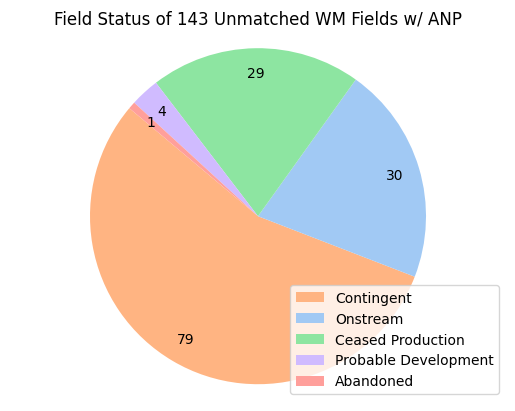

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_pie_chart(df, column_name,colors= None, title=None,loc='lower right'):
    """
    Plots a pie chart of the distribution of categories in a specified column of a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column for which to plot the pie chart.

    Returns:
    None
    """
    # Count occurrences of each category
    category_counts = df[column_name].value_counts()
    if colors == None:
        c = sns.color_palette('pastel')[0:len(category_counts)]
    else:
        c =[colors[v] for v in df[column_name].value_counts().keys()]

    # Plot pie chart
    plt.figure()
    # plt.pie(category_counts, autopct='%1.1f%%',pctdistance=0.85, colors=colors, startangle=140)
    plt.pie(category_counts, autopct=lambda x: '{:.0f}'.format(x*len(df[column_name])/100),pctdistance=0.85, startangle=140,
            colors=c)
    
    if title == None:
        plt.title(f'Category Distribution for {column_name}', fontsize=14)
    else:
        plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Add legend
    plt.legend(category_counts.index,bbox_to_anchor=(1,0), loc=loc)
    
    plt.show()

wm_color_label = {}
n = len(wm_fieldinfo_unmatch_anp['field_status'].unique())
for i in range(0,n):
    wm_color_label[wm_fieldinfo_unmatch_anp['field_status'].unique()[i]] = sns.color_palette('pastel',n).as_hex()[i]
    
plot_category_pie_chart(wm_fieldinfo_unmatch_anp, 'field_status',title='Field Status of 143 Unmatched WM Fields w/ ANP',
                        colors = wm_color_label)


In [77]:
wm_unmatch = wm[wm['Field ID'].isin(no_match_field[no_match_field['Source Name']=='wm']['Field ID'])]
wm_fieldinfo_unmatch = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm_unmatch['Original ID'])]
wm_fieldinfo_unmatch['field_status']

14               Contingent
18               Contingent
29               Contingent
32               Contingent
38               Contingent
               ...         
679    Probable Development
693              Contingent
707              Contingent
714              Contingent
716       Ceased Production
Name: field_status, Length: 109, dtype: object

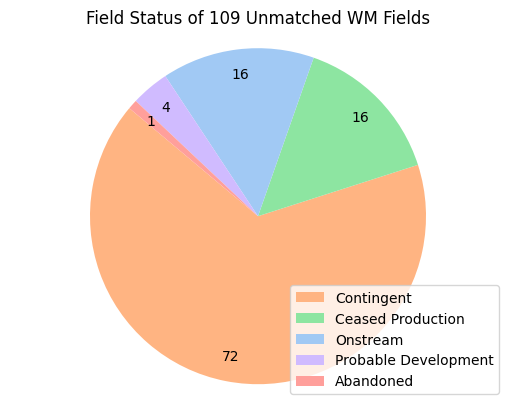

In [138]:
plot_category_pie_chart(wm_fieldinfo_unmatch, 'field_status',title='Field Status of 109 Unmatched WM Fields',
                        colors = wm_color_label)

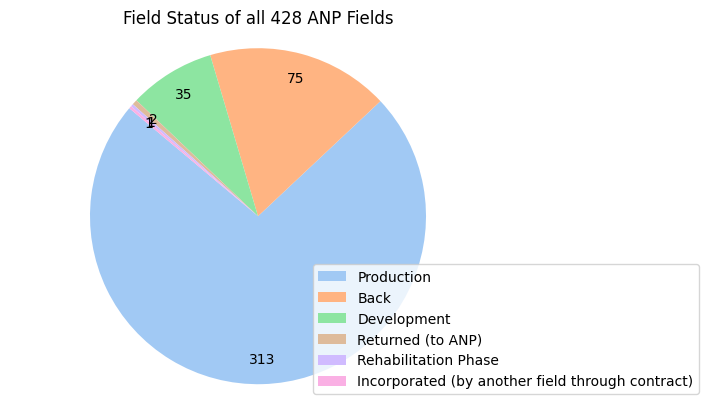

In [103]:
import geopandas as gpd
anp_fieldinfo = gpd.read_file('../data/br_geodata/anp/BR_cleaned.shp')
# print(anp_fieldinfo['Situation'].size)
anp_color_label = {}
n = len(anp_fieldinfo['Situation'].unique())
for i in range(0,n):
    anp_color_label[anp_fieldinfo['Situation'].unique()[i]] = sns.color_palette('pastel',n).as_hex()[i]
plot_category_pie_chart(anp_fieldinfo, 'Situation',title='Field Status of all 428 ANP Fields',loc =8,colors=anp_color_label)

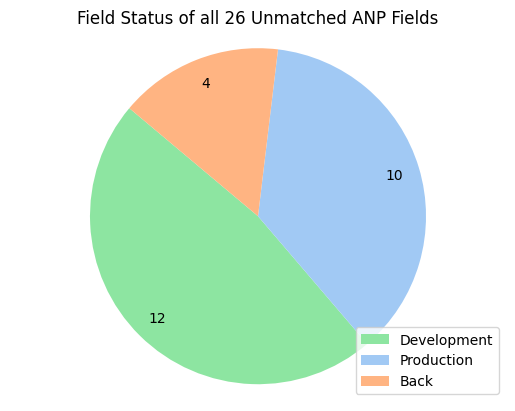

In [137]:
anp_unmatch = anp[anp['Field ID'].isin(no_match_field[no_match_field['Source Name']=='anp']['Field ID'])]
anp_fieldinfo_unmatch = anp_fieldinfo[anp_fieldinfo['Field_ID'].isin(anp_unmatch['Original ID'])]
plot_category_pie_chart(anp_fieldinfo_unmatch, 'Situation',title='Field Status of all 26 Unmatched ANP Fields',colors=anp_color_label,loc=4)

In [123]:
wm

,Unnamed: 0,Field ID,Name,Centroid H3 Index,Source ID,Function unit,Downhole pump,Water reinjection,Natural gas reinjection,Water flooding,...,Ocean tanker,Barge,Pipeline,Rail,Truck,"Ocean tanker size, if applicable",Small sources emissions,geometry,Source Name,Original ID
0,0,0,leste do urucu,898a09cd8c3ffff,wm2022,oil,1,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-65.20220670062687 -4.91142383671405...,wm,8897.0
1,1,1,rio urucu,898a09c48cfffff,wm2022,oil,1,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-65.30670133738988 -4.94208751468800...,wm,8898.0
2,2,2,agua grande,8981162e473ffff,wm2022,oil,0,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.37039521151154 -12.4154700758731...,wm,8899.0
3,3,3,apraius,898112935b3ffff,wm2022,oil,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.166209073504405 -12.287896446348...,wm,8900.0
4,4,4,aracas,8981129197bffff,wm2022,oil,0,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.18997641678381 -12.1723347143959...,wm,8901.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,523,523,campainha azul,89818b10a5bffff,wm2022,oil,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-36.911292403158804 -5.3077883328259...,wm,52671.0
524,524,524,suindara,89a893b689bffff,wm2022,oil,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-39.82796723592173 -19.1977106350774...,wm,53346.0
525,525,525,gaviao belo,89802e02237ffff,wm2022,gas,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-44.10052945592174 -5.71356188215622...,wm,53497.0
526,526,526,murucututu,8981162a47bffff,wm2022,gas,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-38.18539390967941 -12.4517932270100...,wm,53569.0


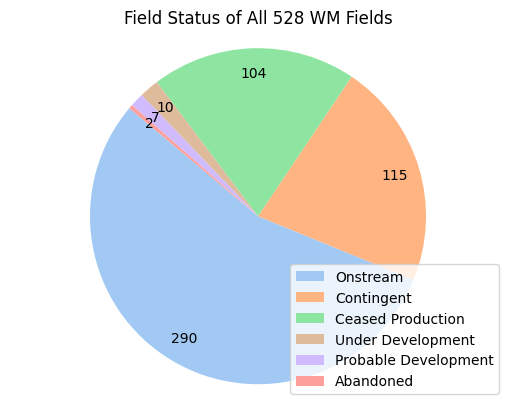

In [125]:
wm_color_label_new = wm_color_label
wm_color_label_new['Under Development'] = sns.color_palette('pastel',6).as_hex()[5]
wm_new = wm_fieldinfo[wm_fieldinfo['id_field'].isin(wm['Original ID'])]
plot_category_pie_chart(wm_new,'field_status',title='Field Status of All 528 WM Fields',colors=wm_color_label_new)

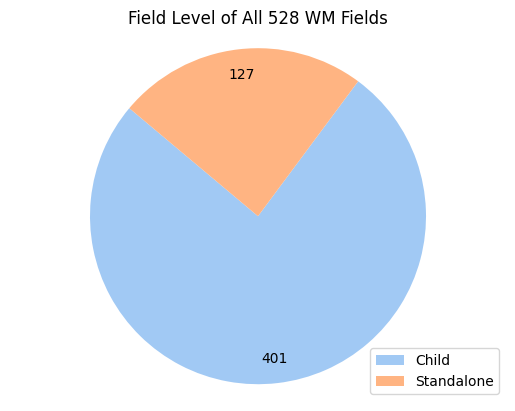

In [129]:
plot_category_pie_chart(wm_new,'field_group_level',title='Field Level of All 528 WM Fields')

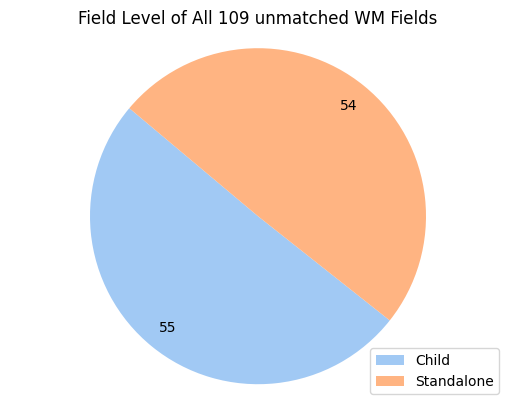

In [131]:
plot_category_pie_chart(wm_fieldinfo_unmatch, 'field_group_level',title='Field Level of All 109 unmatched WM Fields')

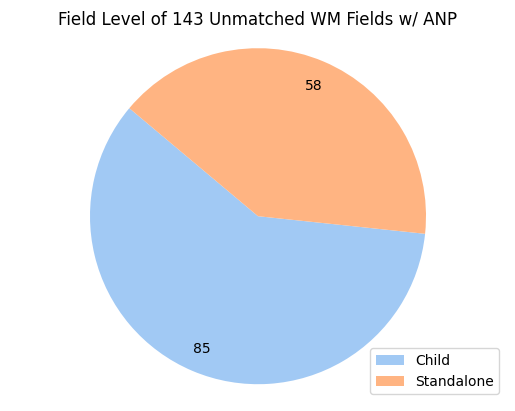

In [133]:
plot_category_pie_chart(wm_fieldinfo_unmatch_anp, 'field_group_level',title='Field Level of 143 Unmatched WM Fields w/ ANP')

In [143]:
import pandas as pd
import numpy as np

def count_non_null_cells(df):
    # Count the number of non-null values in each column and sum them
    non_null_cells = df.count().sum()
    return non_null_cells


df = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table.csv')
print("Number of non-null cells:", count_non_null_cells(df))


Number of non-null cells: 11781


In [146]:
import json
# List of OPGEE columns
with open('../data/OPGEE_cols.json', 'r') as json_file:
    OPGEE_cols = json.load(json_file)
OPGEE_cols['geometry'] = 'geo' #add a column

filtered_df = df.filter(items=OPGEE_cols.keys())
print("Number of non-null cells:", count_non_null_cells(filtered_df))

Number of non-null cells: 8283


In [154]:
df1 = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_v1.csv').filter(items=OPGEE_cols.keys())
df2 = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_v2.csv').filter(items=OPGEE_cols.keys())
df3 = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_v3.csv').filter(items=OPGEE_cols.keys())
df4 = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_v4.csv').filter(items=OPGEE_cols.keys())
df5 = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_v5_paper.csv').filter(items=OPGEE_cols.keys())
df6 = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_v6_paper.csv').filter(items=OPGEE_cols.keys())

In [155]:
OPGEE_data_richness = {
  'ANP':count_non_null_cells(df1),
  'WM':count_non_null_cells(df2),
  'GOGI':count_non_null_cells(df3),
  'Zhan':count_non_null_cells(df4),
  'Paper1':count_non_null_cells(df5),
  'Paper2':count_non_null_cells(df6)
}
OPGEE_data_richness

{'ANP': 3003,
 'WM': 8666,
 'GOGI': 8792,
 'Zhan': 8866,
 'Paper1': 8866,
 'Paper2': 8874}

/var/folders/8z/nrbsy4n11vvd1rdqlg2hf7lw0000gn/T/ipykernel_85924/382440948.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Source', y='OPGEE Data Richness Count', data=df, palette='viridis')


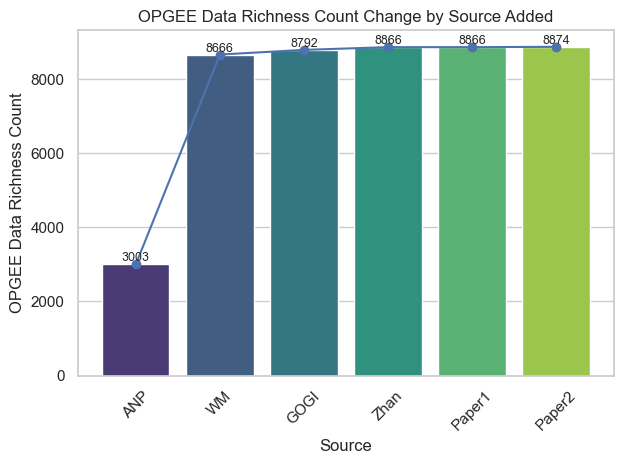

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(OPGEE_data_richness.items()), columns=['Source', 'OPGEE Data Richness Count'])

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure()
barplot = sns.barplot(x='Source', y='OPGEE Data Richness Count', data=df, palette='viridis')

# # Add data labels
for index, row in df.iterrows():
    barplot.bar_label(barplot.containers[index], fontsize=9)

# Add a line plot to connect the counts
plt.plot(df['Source'], df['OPGEE Data Richness Count'], marker='o')

# Customize the plot
plt.title('OPGEE Data Richness Count Change by Source Added')
plt.xlabel('Source')
plt.ylabel('OPGEE Data Richness Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [197]:
wm_standard = pd.read_csv('../data/br_geodata/data_standardization/wm.csv')
wm_unmatch_anp_standard = wm_standard[wm_standard['Field ID'].isin(df_wm_unmatch_with_anp['Field ID'])]
wm_unmatch_anp = wm[wm['id_field_a'].isin(wm_unmatch_anp_standard ['Original ID'])]
wm_unmatch_anp.to_file('../data/br_geodata/unmatch_geo/wm_unmatch_anp.geojson')

In [199]:
anp_unmatch = anp[anp['Field ID'].isin(no_match_field[no_match_field['Source Name']=='anp']['Field ID'])]
anp_fieldinfo_unmatch = anp_fieldinfo[anp_fieldinfo['Field_ID'].isin(anp_unmatch['Original ID'])]
anp_fieldinfo_unmatch.to_file('../data/br_geodata/unmatch_geo/anp_unmatch.geojson')

In [201]:
wm_unmatch_standard = wm_standard[wm_standard['Field ID'].isin(no_match_field[no_match_field['Source Name']=='wm']['Field ID'])]
wm_unmatch = wm[wm['id_field_a'].isin(wm_unmatch_standard ['Original ID'])]
wm_unmatch.to_file('../data/br_geodata/unmatch_geo/wm_unmatch_109.geojson')


,id_field_a,f_depth_mt,waterw_cnt,prodw_cnt,Unnamed_ 0,id_field_p,id_field,field_name,id_field_g,field_grou,...,f_breake_9,f_breake10,f_breake11,f_pi_ratio,f_pi_rat_1,f_pi_rat_2,f_payback_,f_paybac_1,f_paybac_2,geometry
8,8907.0,1459.626667,0,3,14174,bac4cbb6173335e862a1b3df635ee3ba,8907,Canabrava,10770,PetroReconcavo(Bahia),...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-39.75094 -18.59045, -39.75124 -18.5..."
47,8950.0,1441.274194,1,20,20301,c494d9524143b2ebe567475e985c19f7,8950,Riacho Ouricuri,54047,Polo Bahia Terra,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-38.16150 -12.14190, -38.16195 -12.1..."
101,9007.0,1134.285714,0,0,15673,64314c17210c549a854f1f1c7adce8b6,9007,Corrego Grande,9007,Corrego Grande,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-39.89081 -18.78642, -39.89164 -18.7..."
140,9046.0,1319.500000,0,1,26741,71c1806ca28b555c76650f52bb0d2810,9046,Carauna,10769,Ceara-Potiguar Fields,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-37.28902 -4.45602, -37.28924 -4.456..."
148,9054.0,1696.000000,0,0,18722,d2e3e0c2ec10101c41b7f0a11ce93c57,9054,Varzea Redonda,10769,Ceara-Potiguar Fields,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-37.30806 -5.55044, -37.30819 -5.551..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,51371.0,2155.000000,0,0,23970,15d8caecb77542f0f9ee79c4f59d7a3b,51371,Canario da Terra,54047,Polo Bahia Terra,...,None,None,None,NaN,NaN,None,0.0,0.0,None,"POLYGON ((-37.99442 -12.07209, -37.99446 -12.0..."
515,51505.0,6630.000000,0,0,18866,a36bdfdfb17345c5aa69a1c683ac7251,51505,Guanxuma,51505,Guanxuma,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-44.27266 -25.64226, -44.27352 -25.6..."
517,51783.0,4991.666667,0,0,6662,c0d1a45e2391ca3e92684b79affa7dc9,51783,Libra,51783,Libra,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-42.03284 -24.65932, -42.03372 -24.6..."
522,52561.0,1700.000000,0,0,30563,3025ca395092f0ddf8f55952c7f68ab6,52561,Vida,52561,Vida,...,None,None,None,NaN,NaN,None,NaN,NaN,None,"POLYGON ((-39.77920 -19.24287, -39.77924 -19.2..."
